In [0]:
# Ensure to run these codes in Databricks ML mode
# Import the necessary libraries
import mlflow
mlflow.pyspark.ml.autolog()
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer as si
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Ensure the dataset is loaded into FileStore/tables directory
dbutils.fs.ls('/FileStore/tables/steam_200k.csv') # confirm the dataset is in the FileStore/tables directory

[FileInfo(path='dbfs:/FileStore/tables/steam_200k.csv', name='steam_200k.csv', size=8059447, modificationTime=1713439858000)]

###### Schema Definition and Data Loading

In [0]:
# Define the schema
steam_sch = StructType([
    StructField("MemberID", IntegerType(), True),
    StructField("GameName", StringType(), True),
    StructField("MemberBehaviour", StringType(), True),
    StructField("HoursPlayed", DoubleType(), True) 
])
steam_df = spark.read.csv('/FileStore/tables/steam_200k.csv', header= 'false', schema = steam_sch)
steam_df.show(3, truncate=False)


+---------+--------------------------+---------------+-----------+
|MemberID |GameName                  |MemberBehaviour|HoursPlayed|
+---------+--------------------------+---------------+-----------+
|151603712|The Elder Scrolls V Skyrim|purchase       |1.0        |
|151603712|The Elder Scrolls V Skyrim|play           |273.0      |
|151603712|Fallout 4                 |purchase       |1.0        |
+---------+--------------------------+---------------+-----------+
only showing top 3 rows



## EXPLORATORY DATA ANALYSIS

In [0]:
# Confirm the schema
steam_df.printSchema()

root
 |-- MemberID: integer (nullable = true)
 |-- GameName: string (nullable = true)
 |-- MemberBehaviour: string (nullable = true)
 |-- HoursPlayed: double (nullable = true)



In [0]:
# Summary statistics for numerical columns
steam_df.describe().show()

+-------+-------------------+----------------+---------------+------------------+
|summary|           MemberID|        GameName|MemberBehaviour|       HoursPlayed|
+-------+-------------------+----------------+---------------+------------------+
|  count|             200000|          200000|         200000|            200000|
|   mean|  1.0365586594664E8|           140.0|           NULL|17.874383999999914|
| stddev|7.208073512913968E7|             0.0|           NULL|138.05695165086792|
|    min|               5250|     007 Legends|           play|               0.1|
|    max|          309903146|theHunter Primal|       purchase|           11754.0|
+-------+-------------------+----------------+---------------+------------------+



In [0]:
steam_df.show(3, truncate=False)

+---------+--------------------------+---------------+-----------+
|MemberID |GameName                  |MemberBehaviour|HoursPlayed|
+---------+--------------------------+---------------+-----------+
|151603712|The Elder Scrolls V Skyrim|purchase       |1.0        |
|151603712|The Elder Scrolls V Skyrim|play           |273.0      |
|151603712|Fallout 4                 |purchase       |1.0        |
+---------+--------------------------+---------------+-----------+
only showing top 3 rows



In [0]:
# Get the number of records in the dataset/dataframe
print(f'The Total Number of Records in the Dataset: \t {steam_df.count()}')

The Total Number of Records in the Dataset: 	 200000


In [0]:
# Check the distribution of play and purchase in the MemberBehaviour
Status_dist = steam_df.groupBy("MemberBehaviour").count().orderBy("count", ascending=False)
Status_dist.show()

+---------------+------+
|MemberBehaviour| count|
+---------------+------+
|       purchase|129511|
|           play| 70489|
+---------------+------+



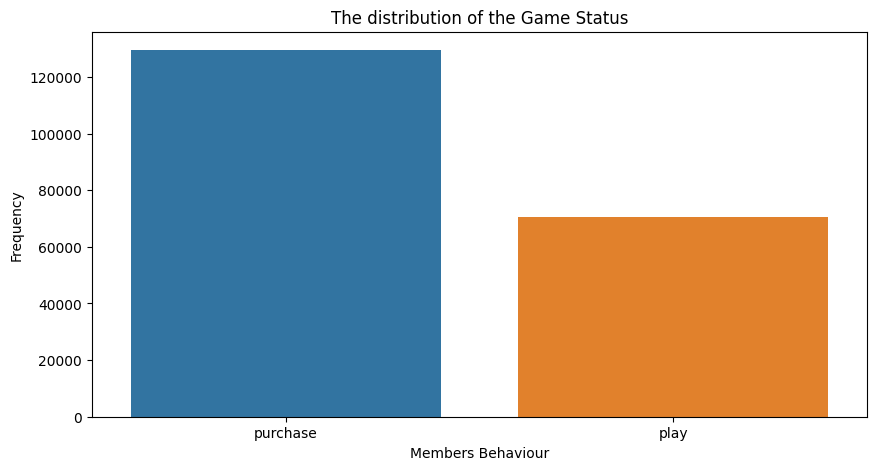

In [0]:
# Convert PySpark DataFrame to Pandas DataFrame and use seaborn to plot the distribution
steam_pd = steam_df.toPandas()

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=steam_pd, x='MemberBehaviour')
plt.title('The distribution of the Game Status')
plt.xlabel('Members Behaviour')
plt.ylabel('Frequency')
plt.show()


##### Data Cleaning Process

In [0]:
# Define a function to check for null values in the dataset
def count_null_values(df):
    null_counts = [df.where(col(c).isNull()).count() for c in df.columns]
    null_counts_dict = dict(zip(df.columns, null_counts))
    return null_counts_dict
null_counts = count_null_values(steam_df) # Call the function to compute the number of null values per column
print("Null value counts for each column:")
print('=' * 36)
print(f'Column_Name\t\tNumberOfNull')
print('=' * 36)
for column, count in null_counts.items():
    print(f"{column.ljust(20)}||\t{count}\t||")
print('=' * 36)

Null value counts for each column:
Column_Name		NumberOfNull
MemberID            ||	0	||
GameName            ||	0	||
MemberBehaviour     ||	0	||
HoursPlayed         ||	0	||


##### There are no null values in the dataset

### Data PREPROCESSING

##### Generate integer IDs for the game name column

In [0]:
# Generate integer IDs for the game name column
indexer = si(inputCol="GameName", outputCol="GameNameID") # Create a StringIndexer transformer
indexer_model = indexer.fit(steam_df) # Fit the StringIndexer on the DataFrame to obtain the mapping
steam_df_with_ids = indexer_model.transform(steam_df) # Transform the DataFrame to add the integer IDs
steam_df_with_ids = steam_df_with_ids.withColumn('GameNameID', steam_df_with_ids['GameNameID'] + 1) # Making sure the ID does not start from 0
steam_df_with_ids.show(5) # Show the resulting DataFrame

2024/04/28 19:49:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9d945c76dd33480f81c82367b4cbffed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


+---------+--------------------+---------------+-----------+----------+
| MemberID|            GameName|MemberBehaviour|HoursPlayed|GameNameID|
+---------+--------------------+---------------+-----------+----------+
|151603712|The Elder Scrolls...|       purchase|        1.0|       9.0|
|151603712|The Elder Scrolls...|           play|      273.0|       9.0|
|151603712|           Fallout 4|       purchase|        1.0|     101.0|
|151603712|           Fallout 4|           play|       87.0|     101.0|
|151603712|               Spore|       purchase|        1.0|     333.0|
+---------+--------------------+---------------+-----------+----------+
only showing top 5 rows



In [0]:
steam_df_with_ids.createOrReplaceTempView('steamView') # Create SQL view

In [0]:
%sql
select * from steamView limit 5

MemberID,GameName,MemberBehaviour,HoursPlayed,GameNameID
151603712,The Elder Scrolls V Skyrim,purchase,1.0,9.0
151603712,The Elder Scrolls V Skyrim,play,273.0,9.0
151603712,Fallout 4,purchase,1.0,101.0
151603712,Fallout 4,play,87.0,101.0
151603712,Spore,purchase,1.0,333.0


### Further Analysis

##### steam_df will be used to model for both play  and purchase behaviours

In [0]:
# Filter out purchase and play to form separate dataframe for the proposed model to be built
steam_play_df = steam_df_with_ids.filter(steam_df_with_ids.MemberBehaviour == 'play') # Play Only dataset filtered out
steam_purchase_df = steam_df_with_ids.filter(steam_df_with_ids.MemberBehaviour == 'purchase') # purchase only dataset

print(f'The Dataframe for play behaviour')
print('==========================================================================')
steam_play_df.show(5) # dataframe for just play behaviour
print(f'The Dataframe for purchase behaviour')
print('==========================================================================')
steam_purchase_df.show(5) # dataframe for just purchase behaviour
print(f'The Dataframe for play and purchase behaviour')
print('==========================================================================')
steam_df_with_ids.show(5) # for Combined behaviours

The Dataframe for play behaviour
+---------+--------------------+---------------+-----------+----------+
| MemberID|            GameName|MemberBehaviour|HoursPlayed|GameNameID|
+---------+--------------------+---------------+-----------+----------+
|151603712|The Elder Scrolls...|           play|      273.0|       9.0|
|151603712|           Fallout 4|           play|       87.0|     101.0|
|151603712|               Spore|           play|       14.9|     333.0|
|151603712|   Fallout New Vegas|           play|       12.1|      30.0|
|151603712|       Left 4 Dead 2|           play|        8.9|       5.0|
+---------+--------------------+---------------+-----------+----------+
only showing top 5 rows

The Dataframe for purchase behaviour
+---------+--------------------+---------------+-----------+----------+
| MemberID|            GameName|MemberBehaviour|HoursPlayed|GameNameID|
+---------+--------------------+---------------+-----------+----------+
|151603712|The Elder Scrolls...|       pu

In [0]:
print('==================================================')
print(f'Dataframe \t\t\t Number of Records')
print('==================================================')
print(f'steam_play_df \t\t\t {steam_play_df.count()}')
print(f'steam_purchase_df \t\t {steam_purchase_df.count()}')
print(f'steam_df_with_ids \t\t {steam_df_with_ids.count()}')

Dataframe 			 Number of Records
steam_play_df 			 70489
steam_purchase_df 		 129511
steam_df_with_ids 		 200000


###### Counts of memberid who played games

+---------+-----+
| MemberID|count|
+---------+-----+
| 62990992|  498|
| 11403772|  314|
|138941587|  299|
| 47457723|  298|
| 49893565|  297|
+---------+-----+
only showing top 5 rows



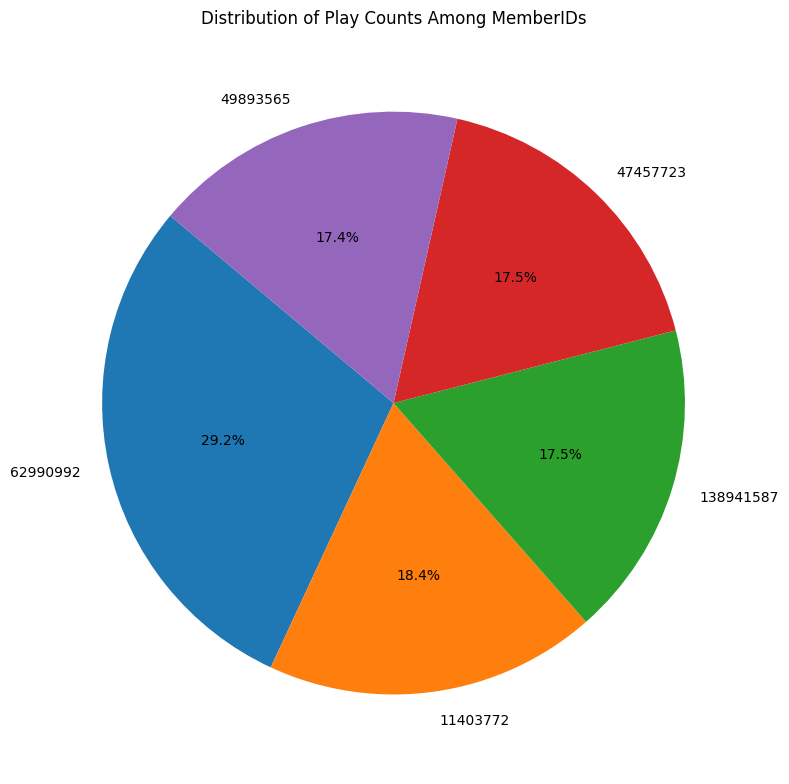

In [0]:
play_Status_MemberID_dist = steam_play_df.groupBy("MemberID").count().orderBy("count", ascending=False)
play_Status_MemberID_dist.show(5)
top_memberids = play_Status_MemberID_dist.limit(5).toPandas() # Extract the top 5 MemberIDs with the highest play counts
# Plot the visual using matplotlib library
plt.figure(figsize=(8, 8))
plt.pie(top_memberids['count'], labels=top_memberids['MemberID'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Play Counts Among MemberIDs')
plt.axis('equal')
plt.tight_layout()
plt.show()


+--------+-----+
|MemberID|count|
+--------+-----+
|62990992| 1075|
|33865373|  783|
|30246419|  766|
|58345543|  667|
|76892907|  597|
+--------+-----+
only showing top 5 rows



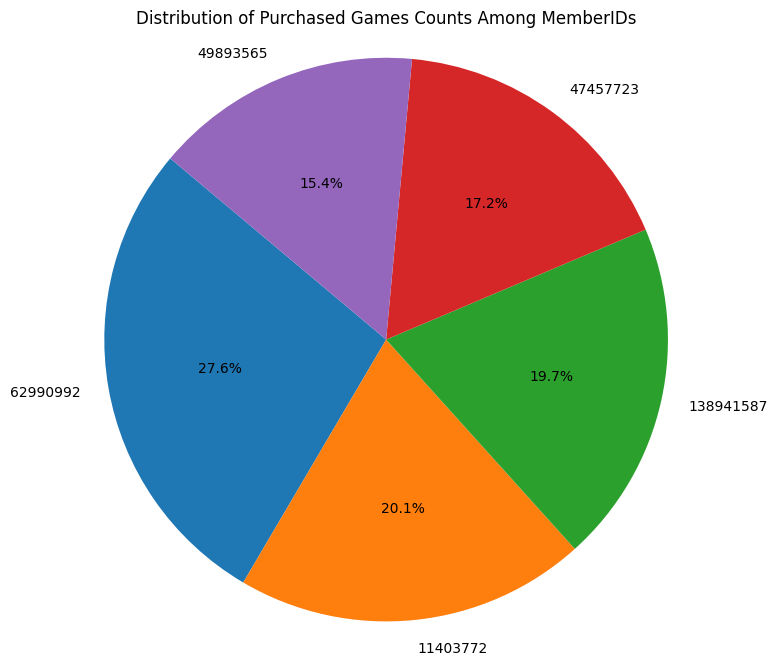

In [0]:
Purchase_Status_MemberID_dist = steam_purchase_df.groupBy("MemberID").count().orderBy("count", ascending=False)
Purchase_Status_MemberID_dist.show(5)
top_memberids_purchased = Purchase_Status_MemberID_dist.limit(5).toPandas() # Extract the top 5 MemberIDs with the highest purchase counts
plt.figure(figsize=(8, 8))
plt.pie(top_memberids_purchased['count'], labels=top_memberids['MemberID'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchased Games Counts Among MemberIDs')
plt.axis('equal') 
plt.show()

###### From the above analysis, the same game player with the highest number of plays was also the person with the highest number of game purchases

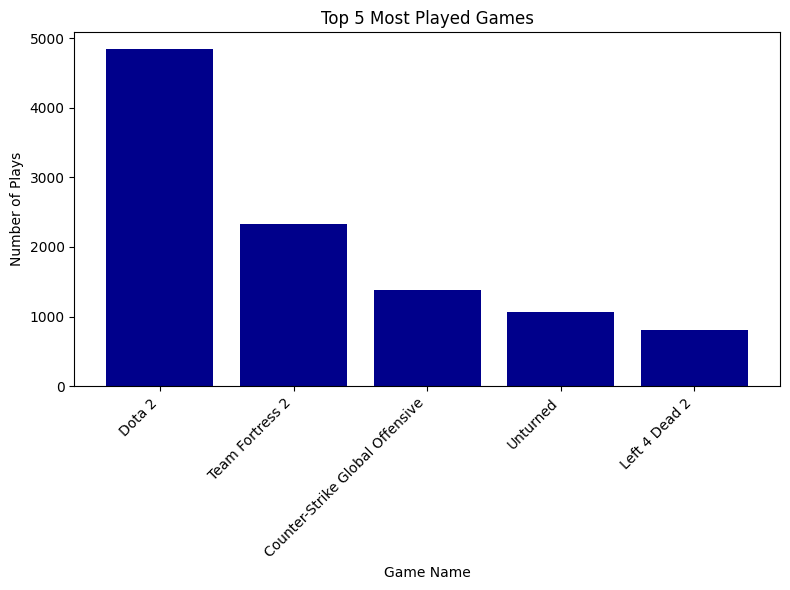

+--------------------+-----+
|            GameName|count|
+--------------------+-----+
|              Dota 2| 4841|
|     Team Fortress 2| 2323|
|Counter-Strike Gl...| 1377|
|            Unturned| 1069|
|       Left 4 Dead 2|  801|
+--------------------+-----+
only showing top 5 rows



In [0]:
higest_game_played = steam_play_df.groupBy("GameName").count().orderBy("count", ascending=False)
top_games = higest_game_played.limit(5).toPandas() # Extract the top 5 most played games
plt.figure(figsize=(8, 6))
plt.bar(top_games['GameName'], top_games['count'], color='darkblue')
plt.title('Top 5 Most Played Games')
plt.xlabel('Game Name')
plt.ylabel('Number of Plays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
higest_game_played.show(5)

+--------------------+-----+
|            GameName|count|
+--------------------+-----+
|              Dota 2| 4841|
|     Team Fortress 2| 2323|
|            Unturned| 1563|
|Counter-Strike Gl...| 1412|
|Half-Life 2 Lost ...|  981|
+--------------------+-----+
only showing top 5 rows



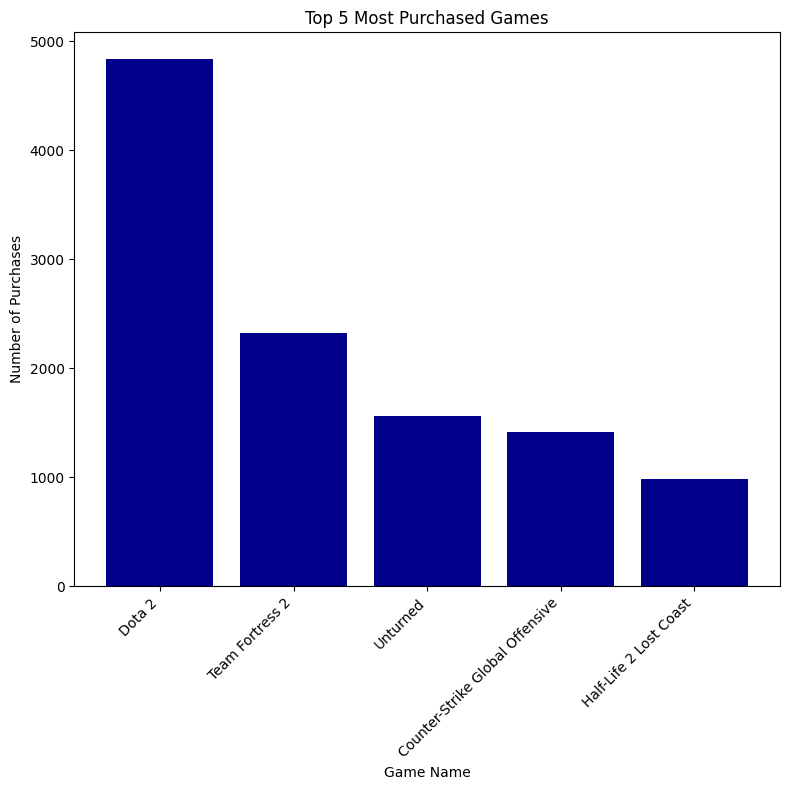

In [0]:
higest_game_purchased = steam_purchase_df.groupBy("GameName").count().orderBy("count", ascending=False)
higest_game_purchased.show(5)
top_games = higest_game_purchased.limit(5).toPandas() # Extract the top 5 most purchased games
plt.figure(figsize=(8, 8))
plt.bar(top_games['GameName'], top_games['count'], color='darkblue')
plt.title('Top 5 Most Purchased Games')
plt.xlabel('Game Name')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


###### Split the datasets for each dataframe into training and test data

In [0]:
# Split the different dataframe into training and test dataset
# (steam_Training_Data, steam_Test_Data) = steam_df_with_ids.randomSplit([0.8,0.2], seed = 100) # Play and Purchase
(steam_Play_Training_Data, steam_Play_Test_Data) = steam_play_df.randomSplit([0.8,0.2], seed = 100) # Play only
(steam_Purchase_Training_Data, steam_Purchase_Test_Data) = steam_purchase_df.randomSplit([0.8,0.2], seed = 100) # Purchase

##### MODELING STARTS HERE

##### Play Model Only
##### Model for member behaviour when the behaviour is play

In [0]:
# Train the play model
steam_play_als = ALS(maxIter = 10, regParam = 0.1, userCol='MemberID', itemCol='GameNameID', ratingCol='HoursPlayed', coldStartStrategy='drop')
steam_play_model = steam_play_als.fit(steam_Play_Training_Data) # fit the training data into the model


2024/04/28 19:50:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd725754d822b49d48999704b6aba1438', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/28 19:50:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Make predictions with the trained model
play_predictions = steam_play_model.transform(steam_Play_Test_Data)
play_predictions.show(5)

+--------+--------------------+---------------+-----------+----------+----------+
|MemberID|            GameName|MemberBehaviour|HoursPlayed|GameNameID|prediction|
+--------+--------------------+---------------+-----------+----------+----------+
|    5250|              Dota 2|           play|        0.2|         1| 628.86676|
|   76767|Call of Duty Blac...|           play|       12.5|        58| -455.1898|
|   76767|Call of Duty Mode...|           play|        9.7|        63|-154.27399|
|   76767|            Portal 2|           play|       15.0|        16| 34.294388|
|   76767|    Worms Armageddon|           play|        0.4|       635|-7.8078203|
+--------+--------------------+---------------+-----------+----------+----------+
only showing top 5 rows



In [0]:
# Play Model Evaluation

steam_play_evaluator = RegressionEvaluator(metricName='rmse', labelCol='HoursPlayed', predictionCol='prediction')
play_rmse = steam_play_evaluator.evaluate(play_predictions)
print('Root Mean Square Error is %g' %play_rmse)

Root Mean Square Error is 380.615


In [0]:
# Game Recommendations for all users to play
userRecs = steam_play_model.recommendForAllUsers(3) # recommend 3 different games for each user (MemberID)
userRecs.show(10, truncate = False)

+--------+---------------------------------------------------------+
|MemberID|recommendations                                          |
+--------+---------------------------------------------------------+
|76767   |[{3965, 4110.1523}, {1954, 3494.6309}, {2133, 3112.6284}]|
|229911  |[{2441, 1529.4608}, {965, 1244.406}, {1381, 1183.6483}]  |
|948368  |[{556, 321.06247}, {619, 313.64392}, {261, 227.07193}]   |
|975449  |[{261, 1395.6688}, {190, 874.9052}, {619, 825.3972}]     |
|1268792 |[{7, 0.49999744}, {965, 0.40600437}, {190, 0.3636421}]   |
|2531540 |[{434, 2809.1575}, {154, 1906.6559}, {1576, 1465.4485}]  |
|2753525 |[{12, 602.8367}, {266, 547.95294}, {154, 512.9474}]      |
|3450426 |[{2456, 324.3784}, {619, 244.2978}, {261, 223.35127}]    |
|4603800 |[{7, 1.5999918}, {965, 1.2992139}, {190, 1.1636548}]     |
|7923954 |[{7, 0.29999846}, {965, 0.24360263}, {190, 0.21818528}]  |
+--------+---------------------------------------------------------+
only showing top 10 rows



In [0]:
#  return the recommendations for a particular Game player whose memberid is 92393218
from pyspark.sql.functions import explode

userRecs.where(userRecs.MemberID == 92393218).select('recommendations')\
.withColumn('recommendations', explode('recommendations'))\
.select('recommendations.GameNameID','recommendations.rating')\
.show(truncate = False)

+----------+---------+
|GameNameID|rating   |
+----------+---------+
|261       |6470.0903|
|619       |4693.0596|
|190       |4130.362 |
+----------+---------+



In [0]:
%sql
-- Get the game names recommended for the memberid 92393218
select GameNameID, GameName from steamView where GameNameID in (261,619,190) and MemberBehaviour = 'play' limit 3

GameNameID,GameName
190.0,Football Manager 2013
619.0,Football Manager 2011
261.0,Football Manager 2012


###### The above games were recommended for the user with MemberID 92393218 to be played

###### Hyperparameters tuning for play only

In [0]:
# Carry out hyperparameter tunings to find the best model from give sets of parameters for rank and regParam
steam_play_als = ALS(userCol='MemberID', itemCol='GameNameID', ratingCol='HoursPlayed', coldStartStrategy='drop')
# Build parameter grid
play_parameters = ParamGridBuilder() \
    .addGrid(steam_play_als.rank, [5, 10, 15]) \
    .addGrid(steam_play_als.regParam, [0.1, 0.5, 1, 5, 10]) \
    .build()


In [0]:
# Evaluate the performance of the play model
play_tvs = TrainValidationSplit()\
    .setSeed(100)\
    .setTrainRatio(0.8)\
    .setEstimatorParamMaps(play_parameters)\
    .setEstimator(steam_play_als)\
    .setEvaluator(steam_play_evaluator)

In [0]:
playgridSearchModel = play_tvs.fit(steam_Play_Training_Data) # find the best parameters that will yield the best rmse

2024/04/28 19:52:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08ea45cc5714476d82a633aad5826219', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/28 19:59:04 WARNING mlflow.pyspark.ml: Model TrainValidationSplitModel_0662402bad59 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:
play_best_model = playgridSearchModel.bestModel # get the best model parameters
print("Parameters for the best model play only:")
print("Rank Parameter: %g" %play_best_model.rank)
print("RegParam Parameter: %g"  %play_best_model._java_obj.parent().getRegParam())

Parameters for the best model play only:
Rank Parameter: 15
RegParam Parameter: 10


### Model for Purchase Only

##### Model for member behaviour when the behaviour is purchase

In [0]:
# Model the purchase model
steam_purchase_als = ALS(maxIter = 10, regParam = 0.1, userCol='MemberID', itemCol='GameNameID', ratingCol='HoursPlayed', coldStartStrategy='drop')
steam_purchase_model = steam_purchase_als.fit(steam_Purchase_Training_Data) # fit the training dataset for the purchase model into the model

2024/04/28 19:59:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fcc0e4308d314c769a42758422191318', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/28 19:59:29 WARNING mlflow.pyspark.ml: Model ALS_2b46a227d3e8 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


##### Prediction for Purchase only

In [0]:
steam_purchase_predictions = steam_purchase_model.transform(steam_Purchase_Test_Data) # predict with the trained purchase model
steam_purchase_predictions.show(5, truncate=False) # show the first 5 predictions

+--------+------------------------------------------+---------------+-----------+----------+----------+
|MemberID|GameName                                  |MemberBehaviour|HoursPlayed|GameNameID|prediction|
+--------+------------------------------------------+---------------+-----------+----------+----------+
|5250    |Counter-Strike Source                     |purchase       |1.0        |6         |0.90020305|
|5250    |Half-Life 2 Deathmatch                    |purchase       |1.0        |14        |0.90012515|
|5250    |Half-Life Blue Shift                      |purchase       |1.0        |75        |0.900112  |
|5250    |Team Fortress Classic                     |purchase       |1.0        |80        |0.90011406|
|76767   |Arma 2 Operation Arrowhead Beta (Obsolete)|purchase       |1.0        |130       |0.90014607|
+--------+------------------------------------------+---------------+-----------+----------+----------+
only showing top 5 rows



In [0]:
# Purchase Model Evaluation
steam_purchase_evaluator = RegressionEvaluator(metricName='rmse', labelCol='HoursPlayed', predictionCol='prediction')
steam_purchase_rmse = steam_play_evaluator.evaluate(steam_purchase_predictions)
print(f'The Root Mean Squared Error for Purchase only Model : \t{steam_purchase_rmse}')
steam_purchase_predictions.display()

The Root Mean Squared Error for Purchase only Model : 	0.10083462434588417


MemberID,GameName,MemberBehaviour,HoursPlayed,GameNameID,prediction
5250,Counter-Strike Source,purchase,1.0,6,0.90020305
5250,Half-Life 2 Deathmatch,purchase,1.0,14,0.90012515
5250,Half-Life Blue Shift,purchase,1.0,75,0.900112
5250,Team Fortress Classic,purchase,1.0,80,0.90011406
76767,Arma 2 Operation Arrowhead Beta (Obsolete),purchase,1.0,130,0.90014607
76767,Call of Duty Modern Warfare 2,purchase,1.0,26,0.9001771
76767,Counter-Strike,purchase,1.0,7,0.90023094
76767,Counter-Strike Global Offensive,purchase,1.0,3,0.9002512
76767,Day of Defeat,purchase,1.0,29,0.9001833
76767,Deathmatch Classic,purchase,1.0,35,0.90018505


In [0]:
# Game Recommendations for all users
purchase_userRecs = steam_purchase_model.recommendForAllUsers(4) # make 4 recommendations for each memberid using the purchase model
purchase_userRecs.show(5, truncate = False)

+--------+------------------------------------------------------------------------------+
|MemberID|recommendations                                                               |
+--------+------------------------------------------------------------------------------+
|76767   |[{3692, 0.90257376}, {1454, 0.9019892}, {3596, 0.9018139}, {2346, 0.9017242}] |
|144736  |[{3692, 0.9025685}, {1454, 0.90187585}, {3596, 0.9017347}, {2346, 0.90157497}]|
|229911  |[{3692, 0.9025112}, {1454, 0.90191936}, {2346, 0.90175045}, {3596, 0.9016895}]|
|835015  |[{3692, 0.90257406}, {1454, 0.9018843}, {3596, 0.9017464}, {2346, 0.90157694}]|
|948368  |[{3692, 0.9025782}, {1454, 0.90192956}, {3596, 0.90177643}, {2346, 0.901637}] |
+--------+------------------------------------------------------------------------------+
only showing top 5 rows



In [0]:
#  return the recommendations for a particular Game purchased by memberid 92393218
from pyspark.sql.functions import explode
purchase_userRecs.where(purchase_userRecs.MemberID == 92393218).select('recommendations')\
.withColumn('recommendations', explode('recommendations'))\
.select('recommendations.GameNameID','recommendations.rating')\
.show(truncate = False)

+----------+----------+
|GameNameID|rating    |
+----------+----------+
|3692      |0.9026015 |
|1454      |0.9020256 |
|3596      |0.9018613 |
|2346      |0.90173733|
+----------+----------+



In [0]:
%sql
-- Get the names of the recommended games
select distinct GameNameID, GameName from steamView where GameNameID in (3692,1454,3596,2346) and MemberBehaviour = 'purchase' limit 4

GameNameID,GameName
3692.0,Tom Clancy's Ghost Recon Phantoms - NA Recon Starter Pack
1454.0,NBA 2K9
2346.0,Dungeon Hearts
3596.0,Pro Cycling Manager Season 2009


###### Hyperparameter tuning for Purchase only

In [0]:
# Carry out hyperparameter tunings to find the best model for purchase from give sets of parameters for rank and regParam
steam_purchase_als = ALS(maxIter=5, userCol='MemberID', itemCol='GameNameID', ratingCol='HoursPlayed', coldStartStrategy='drop')
# Build parameter grid
purchase_parameters = ParamGridBuilder() \
    .addGrid(steam_purchase_als.rank, [5, 10, 15]) \
    .addGrid(steam_purchase_als.regParam, [0.1, 0.5, 1, 5, 10]) \
    .build()

In [0]:
# Carry out hyperparameter tunings to find the best purchase model from give sets of parameters for rank and regParam
from pyspark.ml.tuning import TrainValidationSplit
purchase_tvs = TrainValidationSplit()\
    .setSeed(100)\
    .setTrainRatio(0.8)\
    .setEstimatorParamMaps(purchase_parameters)\
    .setEstimator(steam_purchase_als)\
    .setEvaluator(steam_purchase_evaluator)

In [0]:
purchasegridSearchModel = purchase_tvs.fit(steam_Purchase_Training_Data) # get the best purchase model

2024/04/28 20:00:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6492ffcf544847e7817497c7c87f3c60', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/28 20:04:49 WARNING mlflow.pyspark.ml: Model TrainValidationSplitModel_1890a7be8468 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:

purchase_best_model = purchasegridSearchModel.bestModel # Get the best purchase model parameters
print("Parameters for the best purchase model:")
print("Best Rank Parameter: %g" %purchase_best_model.rank)
print("Best RegParam Parameter: %g" %purchase_best_model._java_obj.parent().getRegParam())

Parameters for the best purchase model:
Best Rank Parameter: 10
Best RegParam Parameter: 0.1
